In [13]:
# load in the climate data

%matplotlib inline
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import numpy as np

from skimage.measure import block_reduce

# from xarray
def _infer_interval_breaks(coord, axis=0):
    coord = np.asarray(coord)
    deltas = 0.5 * np.diff(coord, axis=axis)
    if deltas.size == 0:
        deltas = np.array(0.0)
    first = np.take(coord, [0], axis=axis) - np.take(deltas, [0], axis=axis)
    last = np.take(coord, [-1], axis=axis) + np.take(deltas, [-1], axis=axis)
    trim_last = tuple(slice(None, -1) if n == axis else slice(None)
                      for n in range(coord.ndim))
    return np.concatenate([first, coord[trim_last] + deltas, last], axis=axis)


# from xarray
def _is_monotonic(coord, axis=0):
    coord = np.asarray(coord)

    if coord.shape[axis] < 3:
        return True
    else:
        n = coord.shape[axis]
        delta_pos = (coord.take(np.arange(1, n), axis=axis) >=
                     coord.take(np.arange(0, n - 1), axis=axis))
        delta_neg = (coord.take(np.arange(1, n), axis=axis) <=
                     coord.take(np.arange(0, n - 1), axis=axis))
    
    return np.all(delta_pos) or np.all(delta_neg)

# from xarray
def infer_interval_breaks(x, y, clip=False):
    if len(x.shape) == 1:
        x = _infer_interval_breaks(x)
        y = _infer_interval_breaks(y)
    else:
        # we have to infer the intervals on both axes
        x = _infer_interval_breaks(x, axis=1)
        x = _infer_interval_breaks(x, axis=0)
        y = _infer_interval_breaks(y, axis=1)
        y = _infer_interval_breaks(y, axis=0)

    if clip:
        y = np.clip(y, -90, 90)
        
    return x, y


In [14]:
dir_pictl= 'C:/Users/Schatzli/ML winter school/Projekt/picontrol_CESM/'
tas_pictl= 'tas_CESM12-LE_pictl_0500-5282_yearmean_shiftgrid.nc'

In [15]:
# open the netcdf file in reading mode
ncobj = nc.Dataset(dir_pictl+tas_pictl, mode='r')
 
# Read in what you need (you can also index it like a numpy array if you need just a part of it)
tas = ncobj['TREFHT'][:].data
lon = ncobj['lon'][:].data
lat = ncobj['lat'][:].data
# Close the netcdf file object
ncobj.close()

In [16]:
# the lon / lat grid
lons, lats = np.meshgrid(lon,lat)

# the lon / lat for the plotting with pcolormesh
lon_pc, lat_pc = infer_interval_breaks(lon, lat)

In [17]:
#Data norming on mean
tas_avg= np.average(tas[:100],axis=0)

tas_an = tas-tas_avg

print(tas_an.shape)

(4783, 96, 144)


In [18]:
tas_an.max(),tas_an.min()

(10.469452, -10.259338)

In [19]:
tas_an_red4 = block_reduce(tas_an,(1,4,4), func=np.mean) #Data resolution reduce
tas_an_red4.shape, 24*36, tas_an.shape

((4783, 24, 36), 864, (4783, 96, 144))

C:\Users\PDaddy\Anaconda2\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


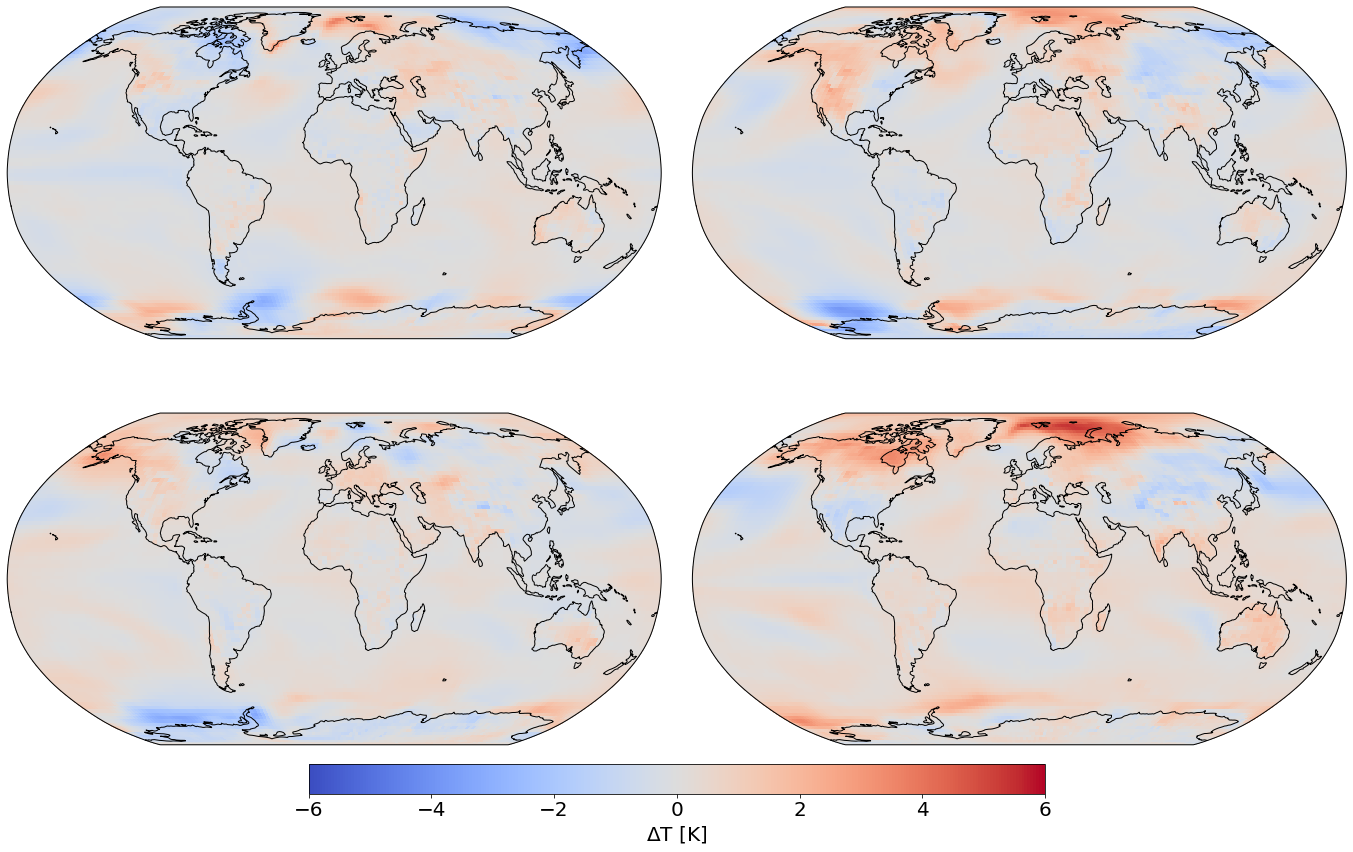

In [16]:
### create the plot
plt.figure(figsize=(24, 18))
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'mathtext.default':'regular'}) 
grid = plt.GridSpec(2, 4, wspace=0.1, hspace=0) # create a grid for the subplots


ax1 = plt.subplot(grid[0,:2], projection=ccrs.Robinson(central_longitude=0))
ax1.coastlines()
mesh1 = ax1.pcolormesh(lon_pc, lat_pc, tas_an[50], cmap='coolwarm',vmin=-6,vmax=6,transform=ccrs.PlateCarree())

ax2 = plt.subplot(grid[0,2:], projection=ccrs.Robinson(central_longitude=0))
ax2.coastlines()
mesh = ax2.pcolormesh(lon_pc, lat_pc, tas_an[2500],cmap='coolwarm',vmin=-6,vmax=6,transform=ccrs.PlateCarree())

ax3 = plt.subplot(grid[1,:2], projection=ccrs.Robinson(central_longitude=0))
ax3.coastlines()
mesh3 = ax3.pcolormesh(lon_pc, lat_pc, tas_an[3500], cmap='coolwarm',vmin=-6,vmax=6,transform=ccrs.PlateCarree())

ax4 = plt.subplot(grid[1,2:], projection=ccrs.Robinson(central_longitude=0))
ax4.coastlines()
mesh = ax4.pcolormesh(lon_pc, lat_pc, tas_an[4500],cmap='coolwarm',vmin=-6,vmax=6,transform=ccrs.PlateCarree())

cbar=plt.colorbar(mesh,ax=[ax1,ax2,ax3,ax4],orientation='horizontal',shrink=0.55,pad=0.02,aspect=25)
cbar.set_label('$\Delta T$ [K]')  

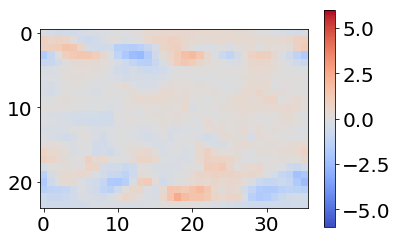

In [17]:
plt.imshow(block_reduce(tas_an[50],(4,4), func=np.mean),cmap='coolwarm',vmin=-6,vmax=6)
plt.colorbar()

In [18]:
tas_an_red4 = block_reduce(tas_an,(1,4,4), func=np.mean)
tas_an_red4.shape, 24*36, tas_an.shape

((4783, 24, 36), 864, (4783, 96, 144))